# Tutorial 3: From Clean Signal to Automated Diagnosis

A clean ECG signal is essential, but the ultimate goal is to interpret it. Can we identify different types of heartbeats, especially abnormal ones (arrhythmias)?

In this final tutorial, we will use our second AI model, the **ECG Classifier**, to automatically diagnose individual heartbeats. This model was trained on over 100,000 examples from the MIT-BIH database to recognize five different categories of beats according to the AAMI standard:

-   **N:** Normal Beat
-   **S:** Supraventricular Ectopic Beat (SVEB)
-   **V:** Ventricular Ectopic Beat (VEB)
-   **F:** Fusion Beat
-   **Q:** Unknown Beat

Let's load our pre-processed beats and see what these different arrhythmias look like.

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

# --- Set up our project environment ---
# Change the working directory to the project root for easy imports and pathing
if os.path.basename(os.getcwd()) == 'tutorials':
    os.chdir('..')
print(f"Current working directory set to: {os.getcwd()}")

# --- Import our custom project functions and classes ---
from src.classifier_model import ECGClassifier
from src.data_utils import TARGET_FS

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BEAT_WINDOW_SIZE = 128 # The number of samples in each beat window (128 samples = ~0.5s)
CLASS_MAP = {0: 'N (Normal)', 1: 'S (SVEB)', 2: 'V (VEB)', 3: 'F (Fusion)', 4: 'Q (Unknown)'}


# --- Load the Processed Data ---
print("Loading the pre-processed heartbeat data...")
try:
    all_beats = np.load('all_beats.npy')
    all_labels = np.load('all_labels.npy')
    print("✅ Data loaded successfully!")
except FileNotFoundError:
    print("\n\nERROR: `all_beats.npy` and `all_labels.npy` not found!")
    print("Please run `python -m src.classification_data` from your terminal first to generate them.")

# --- Load the Pretrained Classifier Model ---
print("Loading the pretrained Classifier model...")
classifier_model = ECGClassifier(num_classes=5).to(DEVICE)
classifier_model.load_state_dict(torch.load('models/ecg_classifier_model.pth', map_location=DEVICE))
classifier_model.eval() # Set the model to evaluation mode
print("✅ Classifier loaded successfully!")

Current working directory set to: /Users/mohanarangandesigan/Developer/ecg-denoiser-hackathon
Loading the pre-processed heartbeat data...
✅ Data loaded successfully!
Loading the pretrained Classifier model...
✅ Classifier loaded successfully!


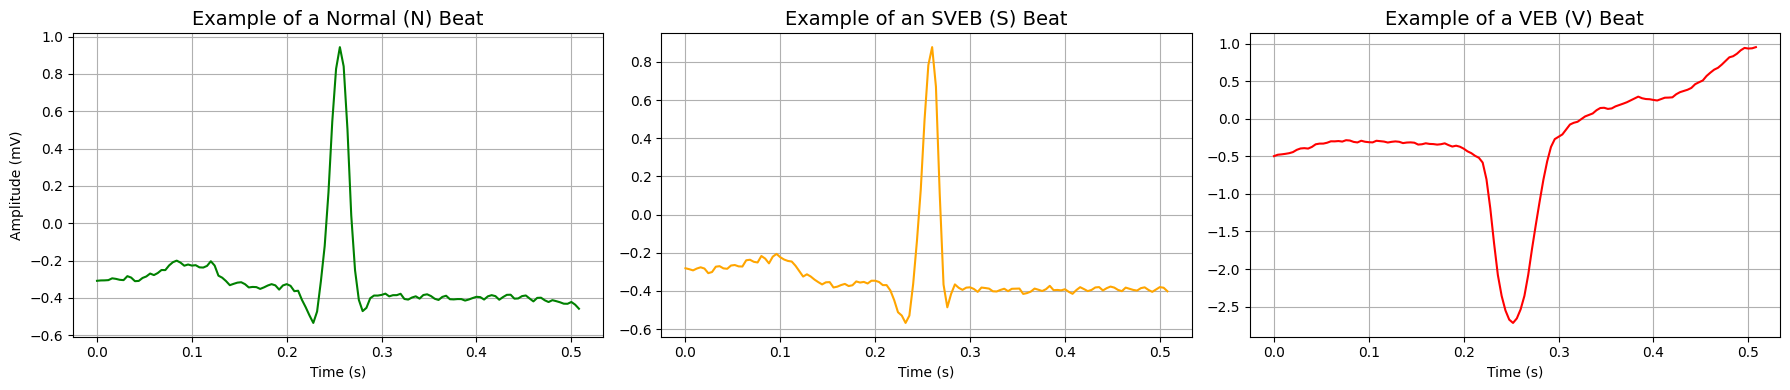

In [2]:
# --- Visualize Different Arrhythmia Types ---
# Let's find one example of each of the three most common types and plot them.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
time_axis = np.arange(BEAT_WINDOW_SIZE) / TARGET_FS

# Find and plot a Normal beat (Label 0)
normal_beat_idx = np.where(all_labels == 0)[0][0]
ax1.plot(time_axis, all_beats[normal_beat_idx], color='green')
ax1.set_title('Example of a Normal (N) Beat', fontsize=14)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (mV)')
ax1.grid(True)

# Find and plot a Supraventricular Ectopic Beat (SVEB - Label 1)
sveb_beat_idx = np.where(all_labels == 1)[0][0]
ax2.plot(time_axis, all_beats[sveb_beat_idx], color='orange')
ax2.set_title('Example of an SVEB (S) Beat', fontsize=14)
ax2.set_xlabel('Time (s)')
ax2.grid(True)

# Find and plot a Ventricular Ectopic Beat (VEB - Label 2)
veb_beat_idx = np.where(all_labels == 2)[0][0]
ax3.plot(time_axis, all_beats[veb_beat_idx], color='red')
ax3.set_title('Example of a VEB (V) Beat', fontsize=14)
ax3.set_xlabel('Time (s)')
ax3.grid(True)

plt.tight_layout()
plt.show()

## What We're Seeing

Notice the differences in shape:
-   The **Normal** beat has a sharp, narrow QRS complex.
-   The **SVEB** (Supraventricular) beat often looks like a normal beat that just came a little too early.
-   The **VEB** (Ventricular) beat is characteristically wide and bizarre-looking. This is a common and important arrhythmia to detect.

Now, let's take one of these beats and see if our AI classifier can correctly identify it.

In [3]:
# --- Classify a Single Beat ---

# Let's grab the VEB beat we plotted above
veb_beat_signal = all_beats[veb_beat_idx]
true_label_index = all_labels[veb_beat_idx]

# Convert the NumPy array to a PyTorch tensor and add batch/channel dimensions
beat_tensor = torch.from_numpy(veb_beat_signal.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(DEVICE)

# Run inference with the classifier
with torch.no_grad():
    prediction_logits = classifier_model(beat_tensor)
    # The output is raw logits, so we apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(prediction_logits, dim=1)
    # Get the index of the highest probability
    predicted_label_index = torch.argmax(probabilities, dim=1).item()

# --- Print the Results ---
print(f"True Beat Type:           {CLASS_MAP[true_label_index]}")
print(f"AI Predicted Beat Type:   {CLASS_MAP[predicted_label_index]}")
print("-" * 30)
print("Prediction Probabilities:")
for i, prob in enumerate(probabilities.squeeze().cpu().numpy()):
    print(f"  - {CLASS_MAP[i]:<15}: {prob:.2%}")

if predicted_label_index == true_label_index:
    print("\n✅ The AI's prediction was correct!")
else:
    print("\n❌ The AI's prediction was incorrect.")

True Beat Type:           V (VEB)
AI Predicted Beat Type:   V (VEB)
------------------------------
Prediction Probabilities:
  - N (Normal)     : 2.95%
  - S (SVEB)       : 0.00%
  - V (VEB)        : 97.03%
  - F (Fusion)     : 0.02%
  - Q (Unknown)    : 0.00%

✅ The AI's prediction was correct!


## Playground: Improving Robustness with Test-Time Augmentation (TTA)

What if a beat is ambiguous or still has some residual noise? We can improve the classifier's confidence by using a technique called **Test-Time Augmentation (TTA)**.

The idea is simple: instead of showing the AI just one version of the beat, we create several slightly modified (augmented) versions and ask the AI to "vote" on the final diagnosis. This makes the final prediction more robust and less sensitive to small variations.

In the code below, we'll write a simple `augment` function and use it to classify a tricky 'S' beat multiple times.

In [ ]:
# --- Playground: Test-Time Augmentation ---
from collections import Counter

def augment_beat(beat_signal):
    """Creates a slightly modified version of a heartbeat signal."""
    # 1. Add a tiny amount of random noise
    augmented_signal = beat_signal * (1 + np.random.normal(0, 0.05)) # 5% scale variance
    
    # 2. Apply a small random time shift (roll the array)
    shift = np.random.randint(-3, 4) # Shift by up to 3 samples left or right
    augmented_signal = np.roll(augmented_signal, shift)
    
    return augmented_signal

# --- Let's test it on a tricky SVEB beat ---
sveb_beat_signal = all_beats[sveb_beat_idx]
true_label_index = all_labels[sveb_beat_idx]

print(f"Classifying a tricky beat of type: {CLASS_MAP[true_label_index]}")
print("-" * 40)

num_augmentations = 10
predictions = []

for i in range(num_augmentations):
    # Create an augmented version
    augmented_beat = augment_beat(sveb_beat_signal)
    
    # Classify the augmented version
    beat_tensor = torch.from_numpy(augmented_beat.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred_label = torch.argmax(classifier_model(beat_tensor), dim=1).item()
        predictions.append(pred_label)
    
    print(f"  - Augmentation #{i+1} Prediction: {CLASS_MAP[pred_label]}")

# --- Aggregate the results with a majority vote ---
final_prediction_index = Counter(predictions).most_common(1)[0][0]

print("-" * 40)
print(f"Final Aggregated Prediction (Majority Vote): {CLASS_MAP[final_prediction_index]}")

if final_prediction_index == true_label_index:
    print("\n✅ The aggregated prediction was correct!")
else:
    print("\n❌ The aggregated prediction was incorrect.")